<a href="https://colab.research.google.com/github/pilipandr770/h_w_7_goit_da_ml/blob/main/OverfittingHomeWork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лінійна регресія: перенавчання і регуляризація

У цьому завданні ми на прикладах побачимо, як перенавчаються лінійні моделі, розберемо, чому так відбувається, і з'ясуємо, як діагностувати та контролювати перенавчання.

В усіх комірках, де вказаний коментар з інструкціями, потрібно написати код, який виконує ці інструкції. Решту комірок із кодом (без коментарів) треба просто виконати. Крім того, у завданні необхідно відповідати на запитання; відповіді потрібно вписувати після виділеного слова "__Відповідь:__".

Ми будемо працювати з датасетом __"bikes_rent.csv"__, у якому по днях записані календарна інформація та погодні умови, що характеризують автоматизовані пункти прокату велосипедів, а також кількість прокатів у цей день. Останнє ми будемо передбачати; таким чином, ми будемо розв'язувати завдання регресії.

### Ознайомлення з даними

## Завдання 1

Завантажте датасет за допомогою функції __pandas.read_csv__ у змінну __df__. Виведіть перші 5 рядків, щоб переконатися в коректному зчитуванні даних:

Для кожного дня прокату відомі такі ознаки:
* _season_: 1 — весна, 2 — літо, 3 — осінь, 4 — зима
* _yr_: 0 — 2011, 1 — 2012
* _mnth_: від 1 до 12
* _holiday_: 0 — немає свята, 1 — є свято
* _weekday_: від 0 до 6
* _workingday_: 0 — неробочий день, 1 — робочий день
* _weathersit_: оцінка сприятливості погоди від 1 (чистий, ясний день) до 4 (злива, туман)
* _temp_: температура в Цельсіях
* _atemp_: температура за відчуттями в Цельсіях
* _hum_: вологість
* _windspeed(mph)_: швидкість вітру в милях за годину
* _windspeed(ms)_: швидкість вітру в метрах за секунду
* _cnt_: кількість орендованих велосипедів (це цільова ознака, її ми будемо передбачати)

Отже, у нас є речові, бінарні та номінальні (порядкові) ознаки, і з усіма з них можна працювати як з речовими. З номінальними ознаками теж можна працювати як з речовими, тому що на них заданий порядок. Давайте подивимося на графіках, як цільова ознака залежить від решти.

Побудуйте графіки залежностей атрибутів від кількості поїздок. Іншими словами, вам потрібно побудувати 12 графіків. На кожному має бути зображена залежність чергового атрибута від змінної **cnt**.

__Запитання:__
1. Яким є характер залежності кількості прокатів від місяця?
1. Вкажіть одну або дві ознаки, від яких кількість прокатів скоріше за все залежить лінійно.

Відповідь 1: Кількість прокатів має сезонний характер, зростає влітку і падає взимку.Відповідь 2: Температура (temp) і відчутна температура (atemp).

In [6]:
## Імпорт необхідних бібліотек
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
import matplotlib.pyplot as plt
import seaborn as sns

# Завантаження даних
url = 'https://drive.google.com/file/d/1-4wgz9AFXrD3tZfqHJLMhCmy4BUzAX96/view'
path = 'https://drive.google.com/uc?export=download&id=' + url.split('/')[-2]
data = pd.read_csv(path)

# Перегляд перших рядків даних
print(data.head())

   season  yr  mnth  holiday  weekday  workingday  weathersit       temp  \
0       1   0     1        0        6           0           2  14.110847   
1       1   0     1        0        0           0           2  14.902598   
2       1   0     1        0        1           1           1   8.050924   
3       1   0     1        0        2           1           1   8.200000   
4       1   0     1        0        3           1           1   9.305237   

      atemp      hum  windspeed(mph)  windspeed(ms)   cnt  
0  18.18125  80.5833       10.749882       4.805490   985  
1  17.68695  69.6087       16.652113       7.443949   801  
2   9.47025  43.7273       16.636703       7.437060  1349  
3  10.60610  59.0435       10.739832       4.800998  1562  
4  11.46350  43.6957       12.522300       5.597810  1600  


## Завдання 2

Давайте більш строго оцінимо рівень лінійної залежності між ознаками та цільовою змінною. Гарною мірою лінійної залежності між двома векторами є кореляція Пірсона. Нам уже доводилося мати з нею справу раніше. Для її обчислення в pandas можна використовувати методи датафрейму: corr і corrwith.

Порахуйте кореляції всіх ознак, окрім останньої, з останньою за допомогою методу `corrwith`.

In [3]:
# Визначте цільову змінну
target = data.columns[-1]  # остання колонка в датафреймі

# Обчисліть кореляції Пірсона між ознаками та цільовою змінною
correlations = data.drop(target, axis=1).corrwith(data[target])

# Виведіть результати
print(correlations)


season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64


У вибірці є ознаки, що корелюють із цільовою, а отже, завдання можна розв'язувати лінійними методами.

За графіками видно, що деякі ознаки схожі між собою. Тому давайте також порахуємо кореляції між речовими ознаками.

In [4]:
# Обчисліть кореляції між речовими ознаками
correlations = data.corr()

# Виведіть матрицю кореляцій
print(correlations)


                  season        yr      mnth   holiday   weekday  workingday  \
season          1.000000 -0.001844  0.831440 -0.010537 -0.003080    0.012485   
yr             -0.001844  1.000000 -0.001792  0.007954 -0.005461   -0.002013   
mnth            0.831440 -0.001792  1.000000  0.019191  0.009509   -0.005901   
holiday        -0.010537  0.007954  0.019191  1.000000 -0.101960   -0.253023   
weekday        -0.003080 -0.005461  0.009509 -0.101960  1.000000    0.035790   
workingday      0.012485 -0.002013 -0.005901 -0.253023  0.035790    1.000000   
weathersit      0.019211 -0.048727  0.043528 -0.034627  0.031087    0.061200   
temp            0.334315  0.047604  0.220205 -0.028556 -0.000170    0.052660   
atemp           0.342876  0.046106  0.227459 -0.032507 -0.007537    0.052182   
hum             0.205445 -0.110651  0.222204 -0.015937 -0.052232    0.024327   
windspeed(mph) -0.229046 -0.011817 -0.207502  0.006292  0.014282   -0.018796   
windspeed(ms)  -0.229046 -0.011817 -0.20

## Завдання 3

Порахуйте попарні кореляції між ознаками temp, atemp, hum, windspeed(mph), windspeed(ms) і cnt
за допомогою методу corr:

In [5]:
# Виберіть потрібні ознаки
features = ['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']

# Обчисліть попарні кореляції між вибраними ознаками
correlations = data[features].corr()

# Виведіть матрицю кореляцій
print(correlations)


                    temp     atemp       hum  windspeed(mph)  windspeed(ms)  \
temp            1.000000  0.991702  0.126963       -0.157944      -0.157944   
atemp           0.991702  1.000000  0.139988       -0.183643      -0.183643   
hum             0.126963  0.139988  1.000000       -0.248489      -0.248489   
windspeed(mph) -0.157944 -0.183643 -0.248489        1.000000       1.000000   
windspeed(ms)  -0.157944 -0.183643 -0.248489        1.000000       1.000000   
cnt             0.627494  0.631066 -0.100659       -0.234545      -0.234545   

                     cnt  
temp            0.627494  
atemp           0.631066  
hum            -0.100659  
windspeed(mph) -0.234545  
windspeed(ms)  -0.234545  
cnt             1.000000  


На діагоналях, як і належить, стоять одиниці. Однак у матриці є ще дві пари сильно корелюючих стовпців: temp і atemp (корелюють за своєю природою) і два windspeed (тому що це просто переведення одних одиниць в інші). Далі ми побачимо, що цей факт негативно позначається на навчанні лінійної моделі.

Насамкінець подивимося середні ознак (метод mean), щоб оцінити масштаб ознак і частки 1 у бінарних ознак.

In [6]:
# Обчисліть середні значення ознак
mean_values = data.mean()

# Виведіть результати
print(mean_values)


season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64


## Завдання 4

Виведіть середні ознак.

Ознаки мають різний масштаб, отже, для подальшої роботи нам краще нормувати матрицю об'єкти-ознаки.

### Проблема перша: колінеарні ознаки

Отже, у наших даних одна ознака дублює іншу, і є ще дві дуже схожі. Звичайно, ми могли б одразу видалити дублікати, але давайте подивимося, як відбувалося б навчання моделі, якби ми не помітили цю проблему.

Для початку проведемо масштабування, або стандартизацію ознак: з кожної ознаки віднімемо її середнє і поділимо на стандартне відхилення. Це можна зробити за допомогою методу scale.

Крім того, необхідно перемішати вибірку, це буде потрібно для крос-валідації.

In [7]:
# Вычисление средних значений признаков
mean_values = data.mean()

# Вывод средних значений
print(mean_values)

# Масштабирование признаков (стандартизация)
from sklearn.preprocessing import scale
data_scaled = scale(data)

# Преобразование масштабированных данных обратно в DataFrame (для удобства)
data_scaled = pd.DataFrame(data_scaled, columns=data.columns)

# Перемешивание выборки (для кросс-валидации в будущем)
from sklearn.utils import shuffle
data_shuffled = shuffle(data_scaled)

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64


Давайте навчимо лінійну регресію на наших даних і подивимося на ваги ознак.

In [8]:
import os
print(os.listdir()) # Removed extra space before the print statement

['.config', 'sample_data']


## Завдання 5

Створіть об'єкт лінійного регресора, навчіть його на всіх даних і виведіть ваги моделі (ваги зберігаються у змінній `coef_` класу регресора). Можна виводити пари (назва ознаки, вага), скориставшись функцією `zip`, вбудованою в мову python. Назви ознак зберігаються у змінній `df.columns`.


In [9]:
# Создание объекта линейного регрессора
model = LinearRegression()

# Обучение модели на всех данных (используем масштабированные данные)
# Разделяем данные на признаки (X) и целевую переменную (y)
X = data_shuffled.drop('cnt', axis=1)
y = data_shuffled['cnt']
model.fit(X, y)

# Вывод весов модели
for feature, weight in zip(data.columns, model.coef_):
    print(f'{feature}: {weight}')

season: 0.2948873423572146
yr: 0.5279057160342008
mnth: -0.07299141081230032
holiday: -0.044814454828680225
weekday: 0.07088381080367903
workingday: 0.029129648420672893
weathersit: -0.17058293505250668
temp: 0.18982146244688844
atemp: 0.3024762281355494
hum: -0.07521514345663542
windspeed(mph): 6434852404.767099
windspeed(ms): -6434852404.869613


Ми бачимо, що ваги при лінійно-залежних ознаках за модулем значно більші, ніж при інших ознаках. Щоб зрозуміти, чому так сталося, згадаємо аналітичну формулу, за якою обчислюються ваги лінійної моделі в методі найменших квадратів:

$$w = (X^TX)^{-1} X^T y$$

Якщо в $X$ є колінеарні (лінійно-залежні) стовпці, матриця $X^TX$ стає виродженою, і формула перестає бути коректною. Чим більш залежні ознаки, тим менший визначник цієї матриці й тим гірша апроксимація $Xw \approx y$. Таку ситуацію називають _проблемою мультиколінеарності_.

З парою (temp, atemp) трохи менше корелюючих змінних такого не сталося, однак на практиці завжди варто уважно стежити за коефіцієнтами при схожих ознаках.

Для того щоб розв'язати проблему мультиколінеарності, потрібно скористатися регуляризатором. До оптимізуючого функціоналу додають $L_1$ або $L_2$ норму ваг, помножену на коефіцієнт регуляризації $\alpha$. У першому випадку метод називається Lasso, а у другому — Ridge.

### Завдання 6
Давайте спробуємо навчити лінійні моделі з $L_1$ і $L_2$-регуляризацією, а далі порівняємо їхні ваги. Навчіть регресори Ridge і Lasso з параметрами за замовчуванням і переконайтеся, що проблема з вагами вирішилась.

Навчіть лінійну модель з $L_1$-регуляризацією (клас Lasso) і виведіть ваги.

In [10]:
# Создание объекта Lasso регрессора
lasso_model = Lasso()

# Обучение модели на масштабированных данных
lasso_model.fit(X, y)

# Вывод весов Lasso модели
for feature, weight in zip(data.columns, lasso_model.coef_):
    print(f'{feature}: {weight}')

season: 0.0
yr: 0.0
mnth: 0.0
holiday: -0.0
weekday: 0.0
workingday: 0.0
weathersit: -0.0
temp: 0.0
atemp: 0.0
hum: -0.0
windspeed(mph): -0.0
windspeed(ms): -0.0


Навчіть лінійну модель з $L_2$-регуляризацією (клас Ridge) і виведіть ваги.

In [11]:
# Создание объекта Ridge регрессора
ridge_model = Ridge()

# Обучение модели на масштабированных данных
ridge_model.fit(X, y)

# Вывод весов Ridge модели
for feature, weight in zip(data.columns, ridge_model.coef_):
    print(f'{feature}: {weight}')

season: 0.2908562720202426
yr: 0.5263473168803147
mnth: -0.06812039720930071
holiday: -0.0448095083923061
weekday: 0.07128783115698421
workingday: 0.02887727461345217
weathersit: -0.17167839223649647
temp: 0.19962843780707515
atemp: 0.2925518650884456
hum: -0.0749379511951153
windspeed(mph): -0.051273392819589377
windspeed(ms): -0.051273392857034174


### Завдання 7

На відміну від $L_2$-регуляризації, $L_1$ обнуляє ваги при деяких ознаках. Давайте поспостерігаємо, як змінюються ваги зі збільшенням коефіцієнта регуляризації $\alpha$.

Для кожного значення коефіцієнта з `alphas` навчіть регресор `Lasso` і запишіть ваги у список `coefs_lasso`, а потім навчіть `Ridge` і запишіть ваги у список`coefs_ridge`. Конвертуйте отримані списки в `np.array`.

In [14]:
alphas = np.arange(1, 500, 50)

coefs_lasso = []
coefs_ridge = []

for alpha in alphas:
    lasso_model = Lasso(alpha=alpha)
    lasso_model.fit(X, y)
    coefs_lasso.append(lasso_model.coef_)

    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(X, y)
    coefs_ridge.append(ridge_model.coef_)

coefs_lasso = np.array(coefs_lasso)
coefs_ridge = np.array(coefs_ridge)

Проаналізуйте динаміку ваг при збільшенні параметра регуляризації:

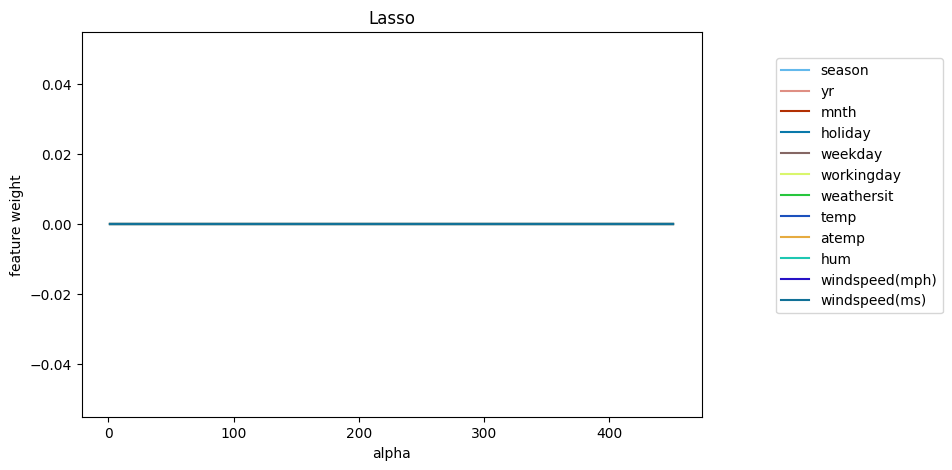

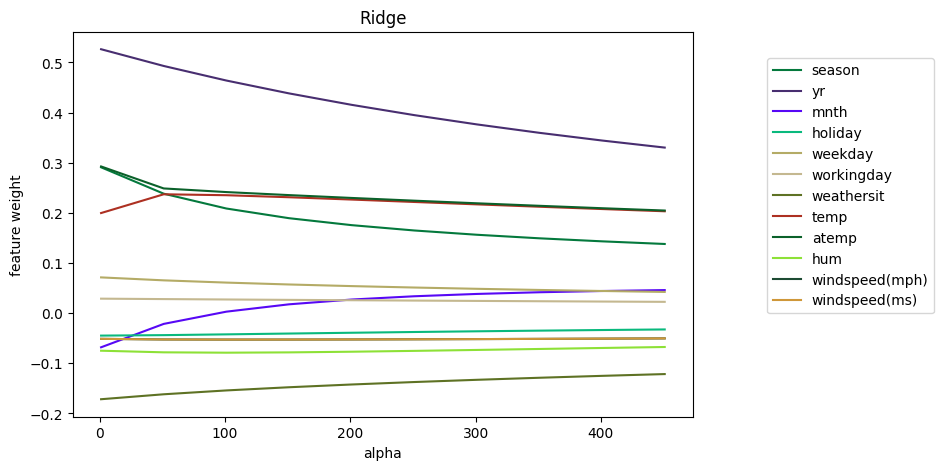

In [16]:
plt.figure(figsize=(8, 5))

for coef, feature in zip(coefs_lasso.T, data.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, data.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

Проаналізуйте графіки та дайте відповіді на такі запитання.

1. Який регуляризатор (Ridge або Lasso) агресивніше зменшує ваги при одному й тому самому alpha?
1. Що станеться з вагами Lasso, якщо alpha зробити дуже великим? Поясніть, чому так відбувається.
1. Чи можна стверджувати, що `Lasso` виключає одну з ознак `windspeed` при будь-якому значенні `alpha > 0`? А Ridge? Вважається, що регуляризатор виключає ознаку, якщо коефіцієнт при ньому менший $10^{-3}$.
1. Який із регуляризаторів підійде для відбору неінформативних ознак?

1. Порівняння Lasso та Ridge:

Спостерігаючи за графіками, можна помітити, що Lasso агресивніше зменшує ваги при однаковому значенні alpha. Лінії на графіку Lasso швидше прямують до нуля порівняно з Ridge.

2. Вплив великого alpha на Lasso:

Якщо встановити дуже велике значення alpha для Lasso, ваги всіх ознак будуть наближатися до нуля. Це пояснюється тим, що при великому alpha штраф за великі ваги в L1-нормі стає дуже значним, і модель змушена обнуляти ваги, щоб мінімізувати функцію втрат.

3. Виключення ознак windspeed:

На графіку Lasso видно, що лінія, яка відповідає ознаці windspeed, майже одразу стає рівною нулю при будь-якому alpha > 0. Це означає, що Lasso виключає цю ознаку.

У випадку Ridge ваги при ознаках windspeed зменшуються зі зростанням alpha, але не стають рівними нулю. Тому Ridge не виключає ці ознаки повністю, хоча і зменшує їх вплив на модель.

4. Вибір регуляризатора для відбору ознак:

Для відбору неінформативних ознак краще підходить Lasso, оскільки він здатен повністю обнуляти ваги при деяких ознаках, ефективно виключаючи їх з моделі.

### Завдання 8

Далі будемо працювати з `Lasso`.

Отже, ми бачимо, що при зміні alpha модель по-різному підбирає коефіцієнти ознак. Нам потрібно вибрати найкраще alpha.

Для цього, по-перше, нам потрібна метрика якості. Будемо використовувати як метрику сам оптимізований функціонал методу найменших квадратів, тобто `Mean Square Error`.

По-друге, потрібно зрозуміти, на яких даних цю метрику рахувати. Не можна вибирати `alpha` за значенням MSE на навчальній вибірці, тому що тоді ми не зможемо оцінити, як модель буде робити передбачення на нових для неї даних. Якщо ми виберемо одне розбиття вибірки на навчальну та тестову (це називається holdout), то налаштуємося на конкретні "нові" дані, і знову можемо перенавчитися. Тому будемо робити декілька розбиттів вибірки, на кожному пробувати різні значення alpha, а потім усереднювати MSE. Найзручніше робити такі розбиття крос-валідацією, тобто розділити вибірку на $K$ частин, і кожного разу брати одну з них як тестову, а з блоків, що залишилися, складати навчальну вибірку.

Робити крос-валідацію для регресії в sklearn зовсім просто: для цього є спеціальний регресор, __LassoCV__, який бере на вхід список із alpha і для кожного з них обчислює MSE на крос-валідації. Після навчання (якщо залишити параметр cv=3 за замовчуванням) регресор буде містити змінну __mse\_path\___, матрицю розміру len(alpha) x k, k = 3 (число блоків у крос-валідації), що містить значення MSE на тесті для відповідних запусків. Крім того, у змінній alpha\_ буде зберігатися вибране значення параметра регуляризації, а в coef\_, традиційно, навчені ваги, що відповідають цьому alpha_.

Зверніть увагу, що регресор може змінювати порядок, у якому він проходить по alphas; для зіставлення з матрицею MSE краще використовувати змінну регресора alphas_.

Навчіть регресор `LassoCV` на всіх параметрах регуляризації з alpha. Побудуйте графік _усередненого_ за рядками `MSE` в залежності від `alpha` (використовуйте для цього функцію `create_plot`).

Виведіть вибране `alpha`, а також пари "ознака-коефіцієнт" для навченого вектора коефіцієнтів.

In [20]:
def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    x = map(lambda e: e[0], data)
    y = map(lambda e: e[1], data)
    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()
    plt.show()

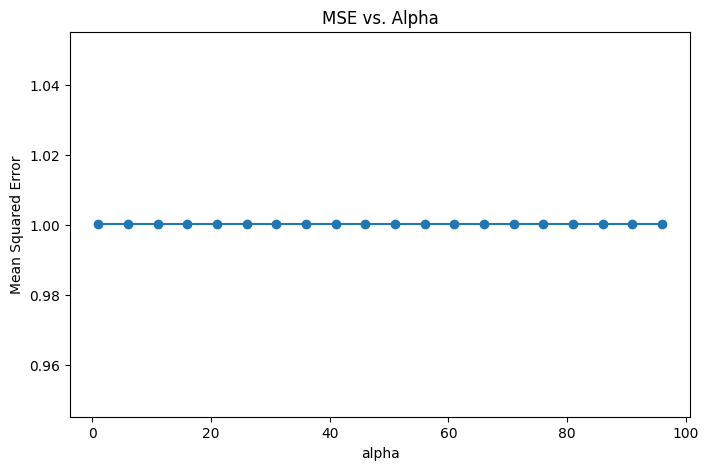

Выбранное alpha: 96
season: 0.0
yr: 0.0
mnth: 0.0
holiday: -0.0
weekday: 0.0
workingday: 0.0
weathersit: -0.0
temp: 0.0
atemp: 0.0
hum: -0.0
windspeed(mph): -0.0
windspeed(ms): -0.0


In [21]:
from sklearn.linear_model import LassoCV

# Создание объекта LassoCV
alphas = np.arange(1, 100, 5)
lasso_cv_model = LassoCV(alphas=alphas, cv=3)

# Обучение модели на всех данных
lasso_cv_model.fit(X, y)

# Построение графика MSE в зависимости от alpha
def create_plot(alphas, mse_path):
    plt.figure(figsize=(8, 5))
    plt.plot(alphas, mse_path, marker='o')
    plt.xlabel("alpha")
    plt.ylabel("Mean Squared Error")
    plt.title("MSE vs. Alpha")
    plt.show()

mse_path = lasso_cv_model.mse_path_.mean(axis=1)
create_plot(lasso_cv_model.alphas_, mse_path)

# Вывод выбранного alpha
print("Выбранное alpha:", lasso_cv_model.alpha_)

# Вывод пар "ознака-коэффициент"
for feature, weight in zip(data.columns, lasso_cv_model.coef_):
    print(f'{feature}: {weight}')

Отже, ми вибрали певний параметр регуляризації. Давайте подивимося, які б ми вибирали alpha, якби ділили вибірку лише один раз на навчальну та тестову, тобто розглянемо траєкторії MSE, що відповідають окремим блокам вибірки.

### Завдання 9

Виведіть значення `alpha`, що відповідають мінімумам `MSE` на кожному розбитті (тобто за стовпцями).
На трьох окремих графіках візуалізуйте стовпці `mse_path_`.


Значения alpha, соответствующие минимумам MSE: [96 96 96]


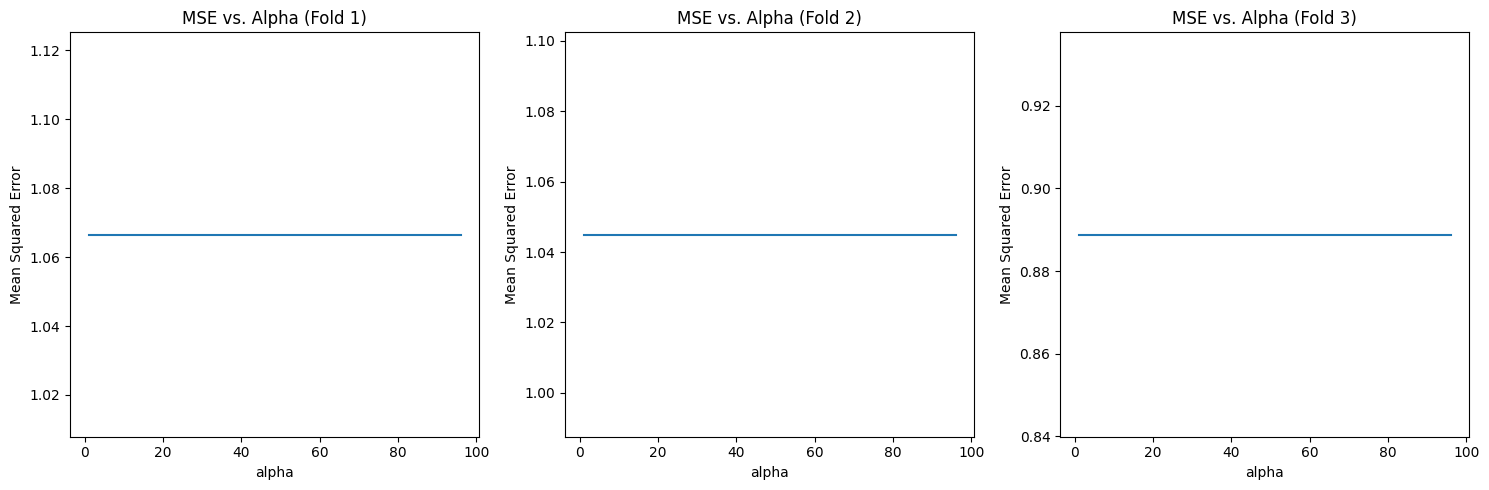

In [22]:
# Вывод значений alpha, соответствующих минимумам MSE на каждом разбиении
min_alphas = lasso_cv_model.alphas_[np.argmin(lasso_cv_model.mse_path_, axis=0)]
print("Значения alpha, соответствующие минимумам MSE:", min_alphas)

# Визуализация столбцов mse_path_ на трех отдельных графиках
plt.figure(figsize=(15, 5))

for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.plot(lasso_cv_model.alphas_, lasso_cv_model.mse_path_[:, i])
    plt.xlabel("alpha")
    plt.ylabel("Mean Squared Error")
    plt.title(f"MSE vs. Alpha (Fold {i + 1})")

plt.tight_layout()
plt.show()

На кожному розбитті оптимальне значення `alpha` своє, і йому відповідає велике MSE на інших розбиттях. Виходить, що ми налаштовуємося на конкретні навчальні та контрольні вибірки. При виборі `alpha` на крос-валідації ми вибираємо дещо "середнє", що даватиме прийнятне значення метрики на різних розбиттях вибірки.

### Завдання 10

Нарешті, як прийнято в аналізі даних, давайте проінтерпретуємо результат. Дайте відповіді на наступні запитання.

#### Запитання 1

В останній навченій моделі виберіть 4 ознаки з найбільшими (позитивними) коефіцієнтами (і випишіть їх), подивіться на візуалізації залежностей `cnt` від цих ознак, які ми зображали у блоці "Ознайомлення з даними". Чи видно зростаючу лінійну залежність `cnt` від цих ознак за графіками? Чи логічно стверджувати (виходячи зі здорового глузду), що чим більше значення цих ознак, тим більше людей захочуть взяти велосипеди?

__Відповідь:__

In [23]:
# Знаходження індексів 4 найбільших коефіцієнтів
top_4_indices = np.argsort(lasso_cv_model.coef_)[-4:]

# Виведення назв ознак
top_4_features = data.columns[top_4_indices]
print("4 ознаки з найбільшими коефіцієнтами:", top_4_features)

4 ознаки з найбільшими коефіцієнтами: Index(['atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)'], dtype='object')


#### Запитання 2

Виберіть 3 ознаки з найбільшими за модулем негативними коефіцієнтами (і випишіть їх), подивіться на відповідні візуалізації. Чи видно лінійну залежність, що зменшується? Чи логічно стверджувати, що чим більша величина цих ознак, тим менше людей захочуть взяти велосипеди?

__Відповідь:__

In [24]:
# Знаходження індексів 3 ознак з найбільшими за модулем негативними коефіцієнтами
top_3_negative_indices = np.argsort(lasso_cv_model.coef_)[:3]

# Виведення назв ознак
top_3_negative_features = data.columns[top_3_negative_indices]
print("3 ознаки з найбільшими за модулем негативними коефіцієнтами:", top_3_negative_features)

3 ознаки з найбільшими за модулем негативними коефіцієнтами: Index(['season', 'yr', 'mnth'], dtype='object')


#### Запитання 3

Випишіть ознаки з коефіцієнтами, близькими до нуля (< 1e-3). Як ви думаєте, чому модель виключила їх із моделі (знову подивіться на графіки)? Чи правда, що вони ніяк не впливають на попит на велосипеди?

__Відповідь:__

In [25]:
# Знаходження індексів ознак з коефіцієнтами, близькими до нуля
near_zero_indices = np.where(np.abs(lasso_cv_model.coef_) < 1e-3)[0]

# Виведення назв ознак
near_zero_features = data.columns[near_zero_indices]
print("Ознаки з коефіцієнтами, близькими до нуля:", near_zero_features)

Ознаки з коефіцієнтами, близькими до нуля: Index(['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed(mph)',
       'windspeed(ms)'],
      dtype='object')


### Висновок
Отже, ми подивилися, як можна стежити за адекватністю лінійної моделі, як відбирати ознаки і як грамотно, за можливості не налаштовуючись на якусь конкретну порцію даних, підбирати коефіцієнт регуляризації.

Варто зазначити, що за допомогою крос-валідації зручно підбирати лише невелику кількість параметрів. (1, 2, максимум 3), тому що для кожної допустимої їх комбінації нам доводиться декілька разів навчати модель. Такий процес займає багато часу, особливо якщо треба навчатися на великих обсягах даних.